In [77]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
plt.rcParams['figure.dpi'] = 100

# 0. Load location and groupings information

In [26]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_222_samples_info.tsv'
file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['sample_ID', 'rookery-region', 'Year', 'group-Lkadj', 
                                         'Management units - based on DNA', 'Post_dupe_depth_2_all_LKGATK_USE',
                                         'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type']]
INFO.rename(columns={'sample_ID':'sample', 
                     'rookery-region':'rookery', 
                     'Year':'year',
                     'group-Lkadj': 'group',
                     'Management units - based on DNA': 'MU',
                     'Post_dupe_depth_2_all_LKGATK_USE':'depth',
                     'Exclude-all_GL_ROH_analyses': 'exclude',
                     'Sequencing_source-type': 'batch'}, inplace=True)

## 0.1 Define colors

In [35]:
rookery_palette_dict = {
    'Mexico': '#1f77b4',
    'Atl Costa Rica': '#005a32',
    'Indonesia': '#d62728',
    'Pacific Costa Rica': '#7570b3',
    'Papua New Guinea': '#dd3497',
    'Solomon Islands': '#fde0dd',
    'Malaysia': '#2ca02c',
    'South Africa': '#17becf',
    'Ghana': '#ff7f0e',
    'Gabon': '#fdd0a2',   
    'French Guiana-Suriname': '#8c564b',
    'Virgin Islands': '#6a51a3',
    'Florida': '#d9f0a3',
    'na': '#000000',
    'unknown': '#7f7f7f'}

mu_palette_dict = {
    'Eastern Pacific': '#1f77b4',
    'Western Pacific': '#d62728',
    'Northwest Caribbean': '#005a32',
    'Northeast Caribbean': '#6a51a3',
    'Northern Caribbean': '#d9f0a3',
    'South Africa': '#17becf',
    'SE Atlantic/West Africa': '#ff7f0e',
    'South-east Caribbean': '#8c564b',
    'Indo-Western Pacific': '#2ca02c',
    'na': '#000000',
    'unknown': '#7f7f7f'}

batch_palette_dict = {
    'novo_UMass_Illumina_SR': '#1f77b4',
    'novo42_Illumina_SR': '#ff7f0e',
    'LR-getinfofromJH': '#2ca02c',
    'Duffy_Illumina_SR': '#d62728'}

population_palette_dict = {
    'larger_declining': '#d62728',
    'small_stable':'#1f77b4',
    'small_declining': '#005a32',
    'larger_stable': '#ff7f0e',
    'small_recovering': '#6a51a3'}

color_dict = {'MU': mu_palette_dict,
              'rookery': rookery_palette_dict,
              'batch': batch_palette_dict,
              'pops': population_palette_dict}

In [32]:
pop_order = ['larger_declining', 'small_stable', 'small_declining', 'larger_stable', 'small_recovering']

# 1. Genetic load analysis

In [125]:
## Read summary file with total number of variants by impact
dc = '222'
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = f'snpEff_{dc}/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location info to each sample
df = df[df['state'] != 'hom_ref']
df_all = pd.merge(df, INFO, on='sample')

## Exclude samples that are not for genetic load analysis
df_all['exclude'] = df_all['exclude'].fillna('include')

## Exclude all new samples. For now
# df_all = df_all[df_all['sample'].str.startswith('dc_')]

In [30]:
df_all.head()

sample    impact state  number variant             rookery    year  \
0  Z005878      HIGH   hom     125    snps  Pacific Costa Rica  1994.0   
1  Z005878  MODERATE   hom    2697    snps  Pacific Costa Rica  1994.0   
2  Z005878       LOW   hom    3352    snps  Pacific Costa Rica  1994.0   
3  Z005878  MODIFIER   hom  439935    snps  Pacific Costa Rica  1994.0   
4  Z005878      HIGH   het     218    snps  Pacific Costa Rica  1994.0   

              group               MU  depth  exclude               batch  
0  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
1  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
2  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
3  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
4  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR

## 1.1. Plot total number of variants by impact
### NB: each impact can additionally be MODIFIER (snpEff can annotate a SNP as both HIGH and MODIFIER) => MODIFIER here are variants that are annotated ONLY as modifier and no other class! 

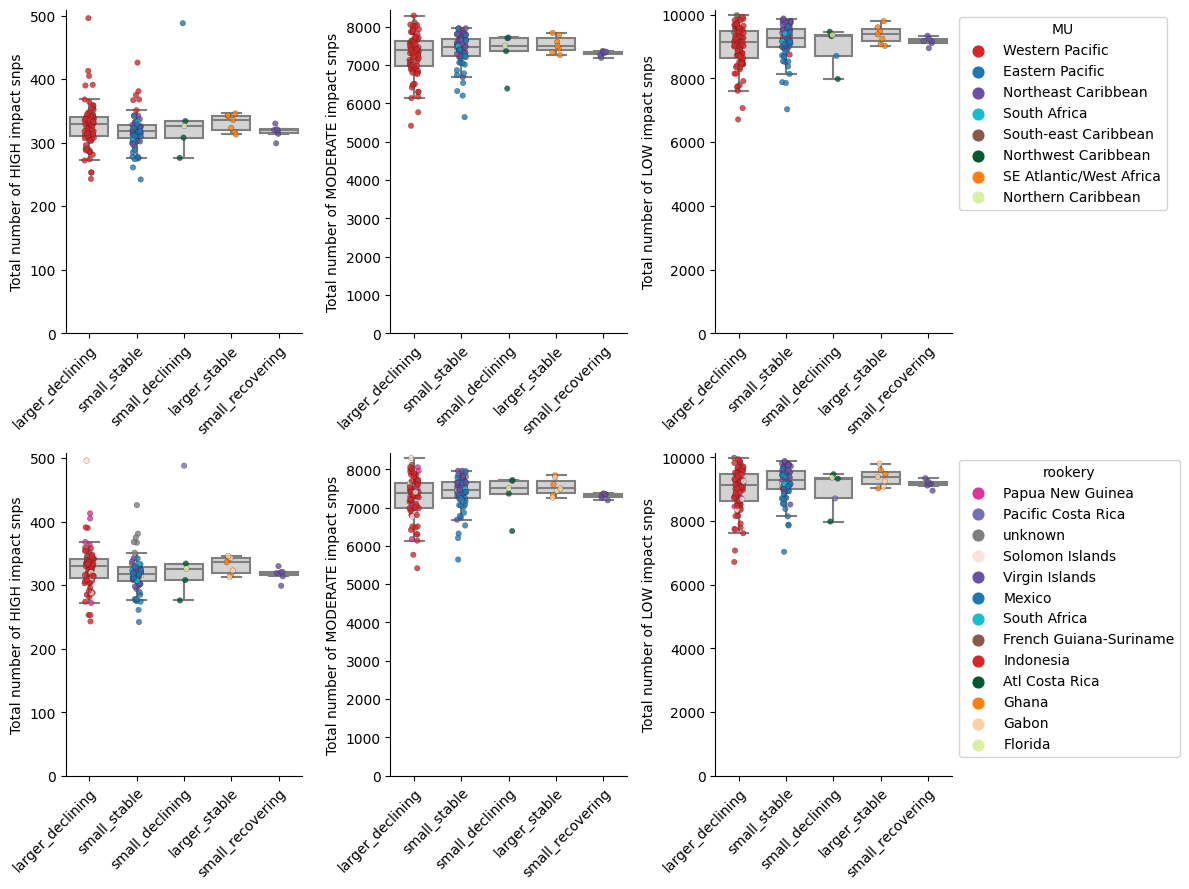

In [69]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'rookery', 'year', 'group', 'exclude', 'batch']).sum().reset_index()

# Exclude 'MODIFIER' snps
grouped_df = grouped_df[grouped_df['impact'] != 'MODIFIER']
impacts = ['HIGH', 'MODERATE', 'LOW']

fig, axes = plt.subplots(2, 3, figsize=(12, 9))

groups = ['MU', 'rookery']

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]

        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, 
                    color="lightgrey", order=pop_order)
        sns.stripplot(ax=axi, data=dfi, x='group', y='number',  hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact snps')
        axi.set_xlabel('')
        axi.set_ylim(0, None)
        
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

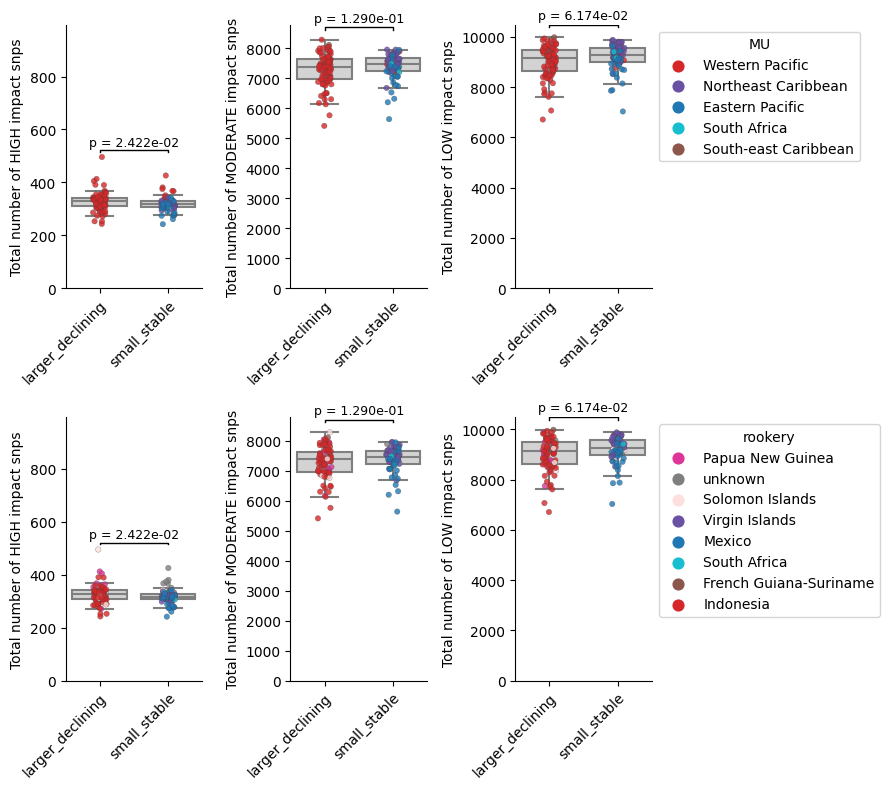

In [100]:
impacts = ['HIGH', 'MODERATE', 'LOW']
groups = ['MU', 'rookery']
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]

fig, axes = plt.subplots(2, 3, figsize=(9, 8))

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1]['number']
        data2 = dfi[dfi['group'] == g2]['number']

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
    
        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, 
                    color="lightgrey", order=pop_order)
        sns.stripplot(ax=axi, data=dfi, x='group', y='number',  hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact snps')
        axi.set_xlabel('')
        axi.set_ylim(0, max(dfi['number'])+500)
        
        # Add bar and p-value
        y_max = max(dfi['number']) * 1.05        
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=9)
        
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## 1.2. Plot fraction of variants by impact

In [53]:
G = grouped_df.groupby(['sample']).sum().reset_index()[['sample', 'number']]
G.rename({'number': 'total'}, axis='columns', inplace=True)

merged_df = pd.merge(grouped_df, G, on='sample')
merged_df['fraction'] = merged_df['number'] / merged_df['total'] * 100
merged_df.head(3)

sample    impact               MU             rookery    year  \
0  Z005878      HIGH  Eastern Pacific  Pacific Costa Rica  1994.0   
1  Z005878       LOW  Eastern Pacific  Pacific Costa Rica  1994.0   
2  Z005878  MODERATE  Eastern Pacific  Pacific Costa Rica  1994.0   

              group  exclude               batch  number  depth  total  \
0  larger_declining  exclude  novo42_Illumina_SR     343  12.44  14585   
1  larger_declining  exclude  novo42_Illumina_SR    7812  12.44  14585   
2  larger_declining  exclude  novo42_Illumina_SR    6430  12.44  14585   

    fraction  
0   2.351731  
1  53.561879  
2  44.086390

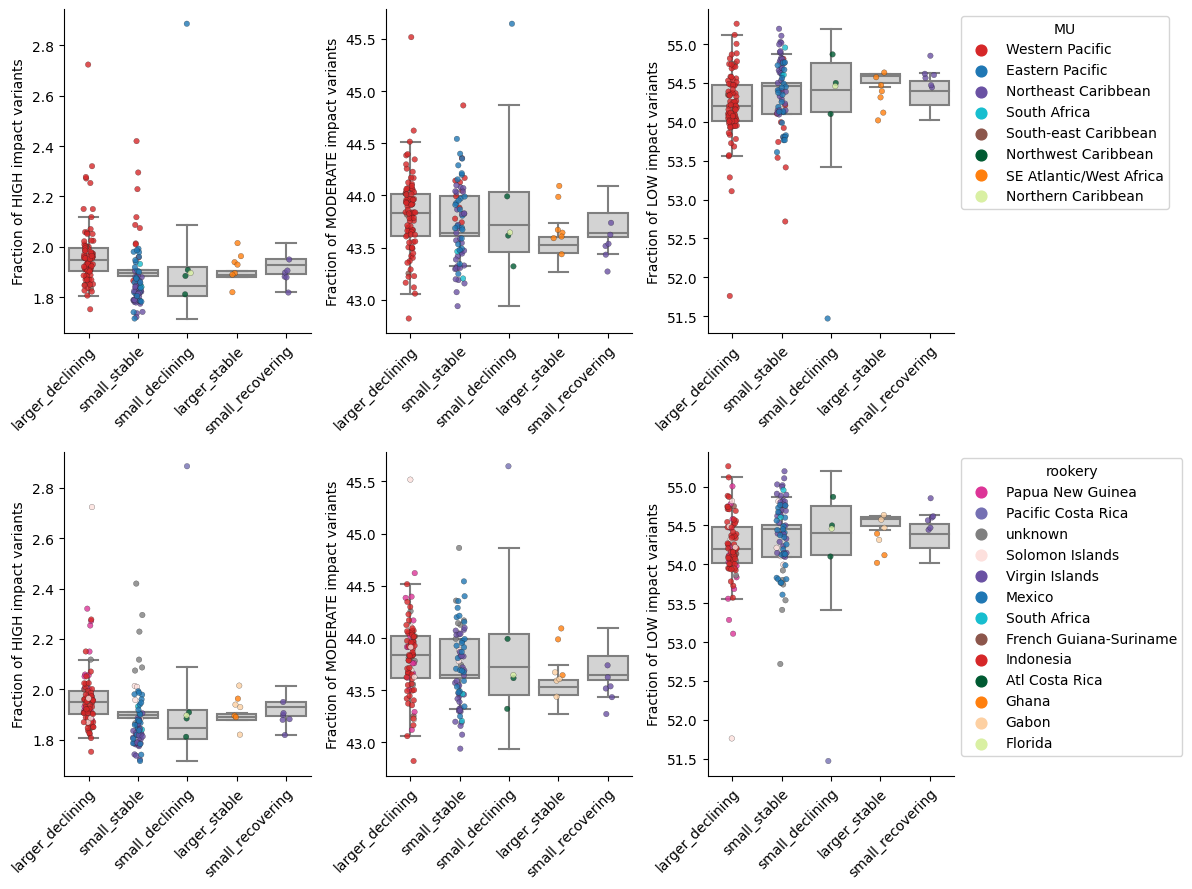

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9))

groups = ['MU', 'rookery']

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = merged_df[merged_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]
        
        sns.boxplot(ax=axi, data=dfi, x='group', y='fraction', showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='fraction', hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Fraction of {impact} impact variants')
        axi.set_xlabel('')

        
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## 1.3. Plot homozygotes and heterozygotes by impact
### NB: all homozygotes are alt alleles! never 0/0, only 1/1, 1|1, and rarely 2/2, 3/3, ... etc for indels

In [21]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_out/all_samples.hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

IndexError: list index out of range

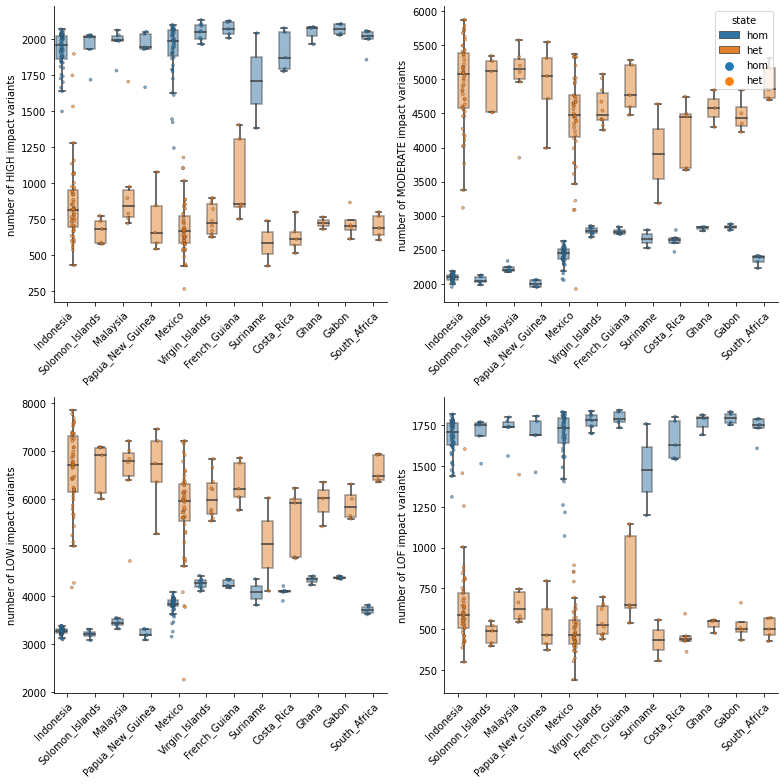

In [53]:
impacts = list(set(df_all['impact']))
fig, axes = plt.subplots(2, 2, figsize = (11, 11))

for i in range(len(impacts)):
    j = i % 2
    k = i // 2
    axi = axes[j][k]
    impact = impacts[i]
    dfi = df_all[df_all['impact'] == impact]
    
    sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                showfliers=False, boxprops=dict(alpha=0.5))
    sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                  alpha=0.6, s=3, dodge=True, linewidth=0.5)
    
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_ylabel('number of {} impact variants'.format(impact))
    axi.set_xlabel('')
    if i != 2:
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### Since the majority of HIGH impact variants are LOF (>70%), classes HIGH and LOF are almost equivalent. Leave only LOF

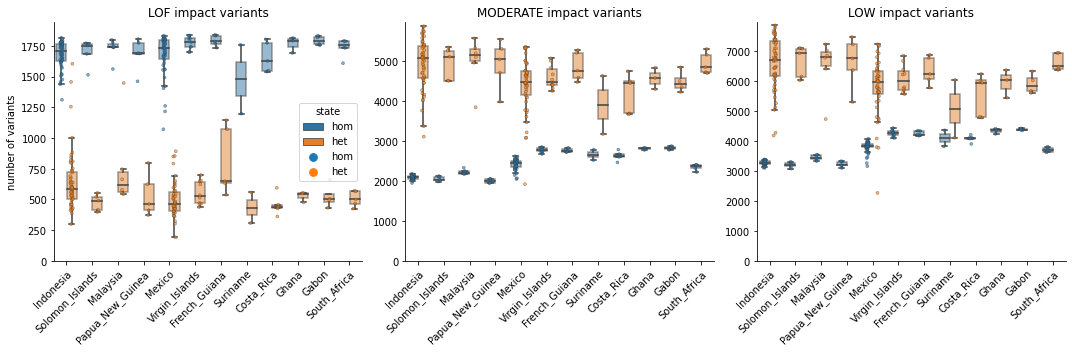

In [54]:
impacts = ['LOF', 'MODERATE', 'LOW']
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i in range(len(impacts)):
    axi = axes[i]
    impact = impacts[i]
    dfi = df_all[df_all['impact'] == impact]
    
    sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                showfliers=False, boxprops=dict(alpha=0.5))
    sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                  alpha=0.6, s=3, dodge=True, linewidth=0.5)
    
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('{} impact variants'.format(impact))
    axi.set_xlabel('')
    axi.set_ylim(0, max(dfi['number']) + 100)
    if i == 0:
        axi.set_ylabel('number of variants')
    else:
        axi.set_ylabel('')
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### Compare directly between number of variants by impact

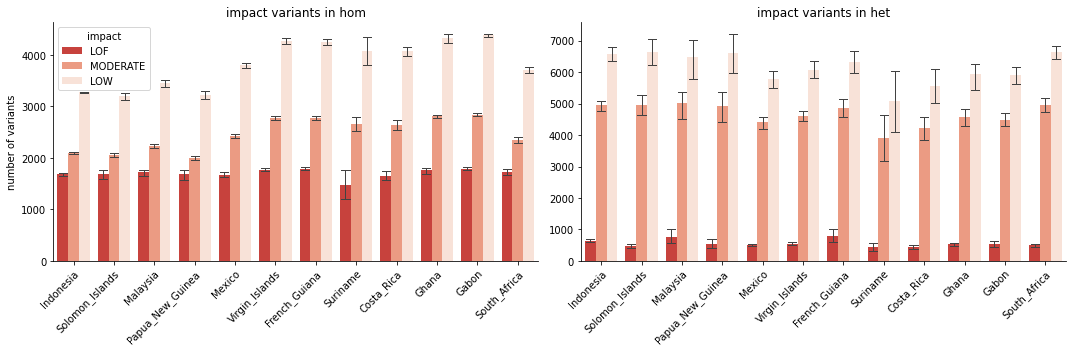

In [112]:
states = ['hom', 'het']
p = sns.color_palette(['#de2d26', '#fc9272', '#fee0d2'])

fig, axes = plt.subplots(1, 2, figsize = (15, 5))

for i in range(len(states)):
    axi = axes[i]
    state = states[i]
    dfi = df_all[(df_all['state'] == state) & (df_all['impact'] != 'HIGH')]
    
    hue_order=['LOF', 'MODERATE', 'LOW']
    sns.barplot(ax=axi, data=dfi, x='country', y='number', hue='impact', order=countries_order, 
                hue_order=hue_order, palette=p, errwidth=1, capsize=0.2)
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('impact variants in {}'.format(state))
    axi.set_xlabel('')
    if i == 0:
        axi.set_ylabel('number of variants')
    else:
        axi.set_ylabel('')
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.4. Separate each impact class into SNPs and indels

In [53]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_out/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df = df[df['state'] != 'hom_ref']

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

sample    impact state  number variant country  year  \
0  dc_100028_bb_noq      HIGH   hom     104    snps  Mexico  2016   
1  dc_100028_bb_noq      HIGH   hom    2025  indels  Mexico  2016   
2  dc_100028_bb_noq  MODERATE   hom    2470    snps  Mexico  2016   

              group  depth  
0  small_recovering  14.38  
1  small_recovering  14.38  
2  small_recovering  14.38

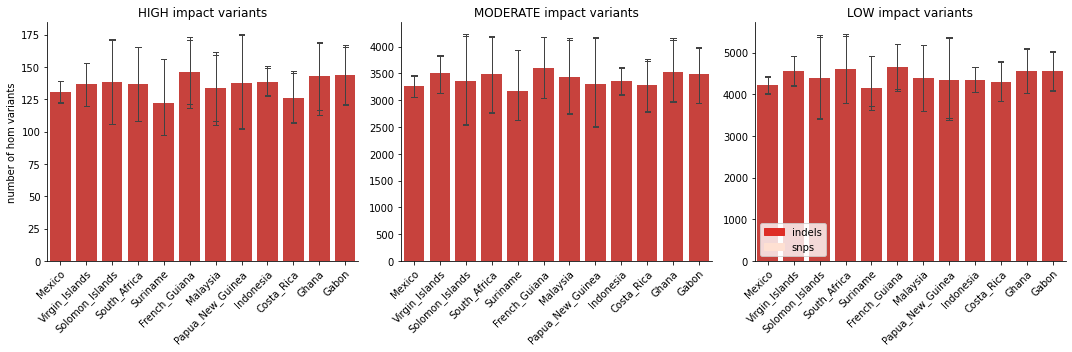

In [46]:
states = ['hom', 'het']
state = 'hom'

variant = 'indels'
df_var = df_all
c_all = '#fee0d2'
c_var = '#de2d26'

impacts = ['HIGH', 'MODERATE', 'LOW']
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i in range(len(impacts)):
    axi = axes[i]
    impact = impacts[i]
    dfi = df_var[(df_var['impact'] == impact) & (df_var['variant'] == var)]
    dfi_var = df_var[(df_var['impact'] == impact) & (df_var['variant'] == var)]
    
    sns.barplot(ax=axi, data=dfi, x='country', y='number', color=c_all, errwidth=1, capsize=0.2)
    sns.barplot(ax=axi, data=dfi_var, x='country', y='number', color=c_var, errwidth=1, capsize=0.2)
    
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('{} impact variants'.format(impact))
    axi.set_xlabel('')
    if i == 0:
        axi.set_ylabel('number of {} variants'.format(state))
    else:
        axi.set_ylabel('')
    
# add custom legend
red_patch = mpatches.Patch(color=c_var, label='indels')
pink_patch = mpatches.Patch(color=c_all, label='snps')
plt.legend(handles=[red_patch, pink_patch])

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.5. Separate variants by impact and by type: snp or indel

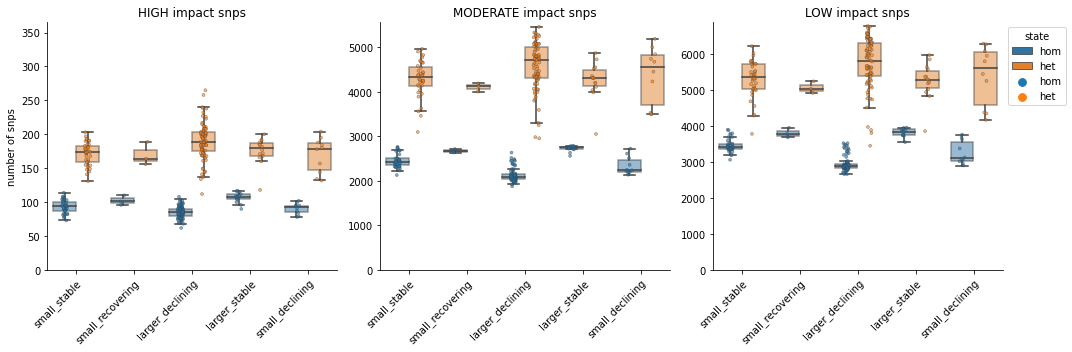

In [22]:
impacts = ['HIGH', 'MODERATE', 'LOW']
variants = ['snps']

fig, axes = plt.subplots(1, 3, figsize = (15, 5))
pal = sns.color_palette('Set2')

for i in range(len(impacts)):
    for j in range(len(variants)):
        
        axi = axes[i]
        impact = impacts[i]
        variant = variants[j]
        dfi = df_all[(df_all['variant'] ==  variant) & (df_all['impact'] ==  impact)]
        dfi = dfi[dfi['exclude'] == 'include']

#         sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
#                     showfliers=False, boxprops=dict(alpha=0.5))
#         sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
#                      alpha=0.6, s=3, dodge=True, linewidth=0.5)
        sns.boxplot(ax=axi, data=dfi, x='group', y='number', hue='state',
                    showfliers=False, boxprops=dict(alpha=0.5))
        sns.stripplot(ax=axi, data=dfi, x='group', y='number', hue='state', 
                     alpha=0.6, s=3, dodge=True, linewidth=0.5)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('{} impact {}'.format(impact, variant))
        axi.set_xlabel('')
        axi.set_ylim(0, max(dfi['number']) + 100)
        if i == 0:
            axi.set_ylabel('number of {}'.format(variant))
        else:
            axi.set_ylabel('')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.6. Plot fraction of homozygots per impact: snpEff

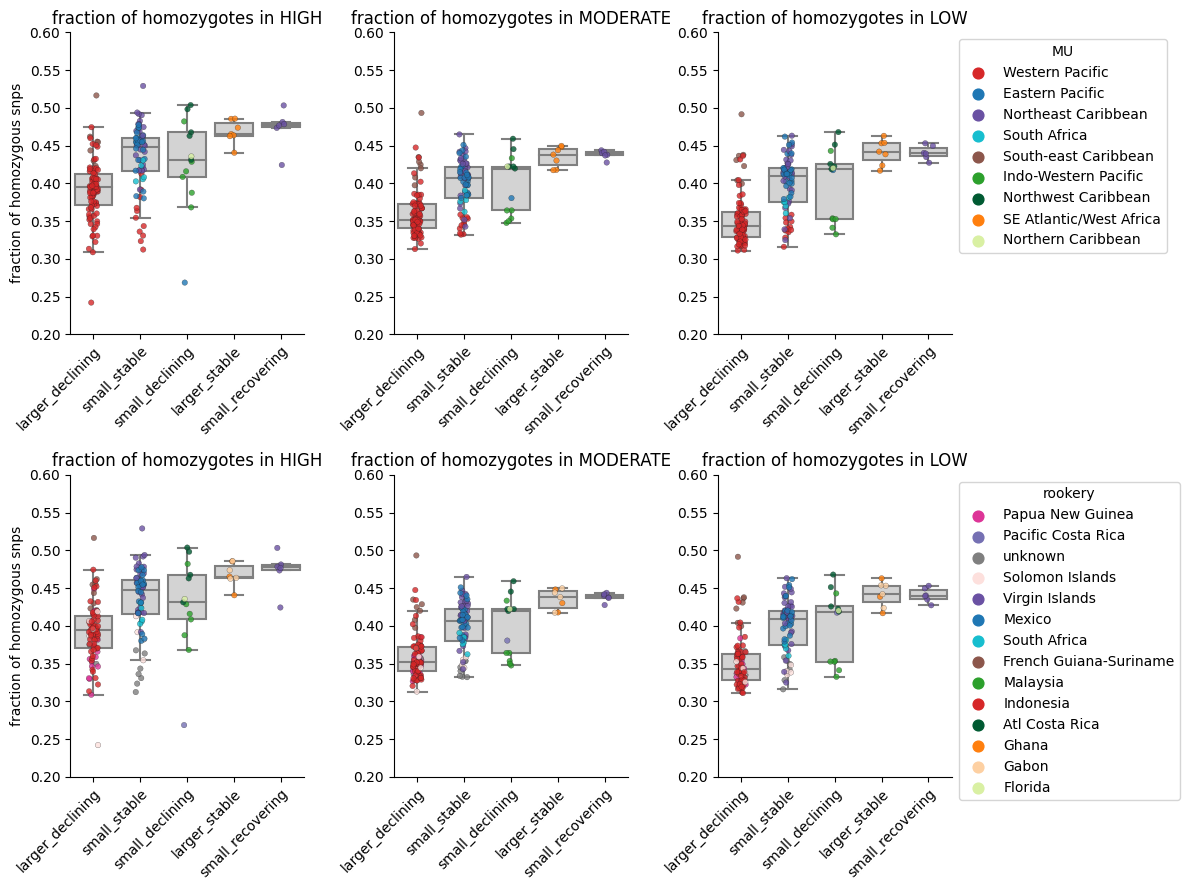

In [67]:
totals = df_all.groupby(["sample", "impact", "variant", "rookery"])["number"].transform("sum")
df_all["fraction"] = df_all["number"] / totals

groups = ['MU', 'rookery']
impacts = ['HIGH', 'MODERATE', 'LOW']
variant = 'snps'
state = 'hom'

fig, axes = plt.subplots(2, 3, figsize = (12, 9))

for j in range(len(groups)):
    for i in range(len(impacts)):
        axi = axes[j][i]
        impact = impacts[i]
        group = groups[j]
        p = color_dict[group]
        
        dfi = df_all[(df_all['variant'] == variant) & (df_all['state'] == state)]
        dfi = dfi[dfi['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']

        sns.boxplot(ax=axi, data=dfi, x='group', y='fraction', order=pop_order,
                    showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='fraction', hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('fraction of homozygotes in {}'.format(impact))
        axi.set_xlabel('')
        axi.set_ylim(0.2, 0.6)
        
        if i == 0:    
            axi.set_ylabel('fraction of homozygous snps')
            axi.get_legend().set_visible(False)
        else:
            axi.set_ylabel('')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

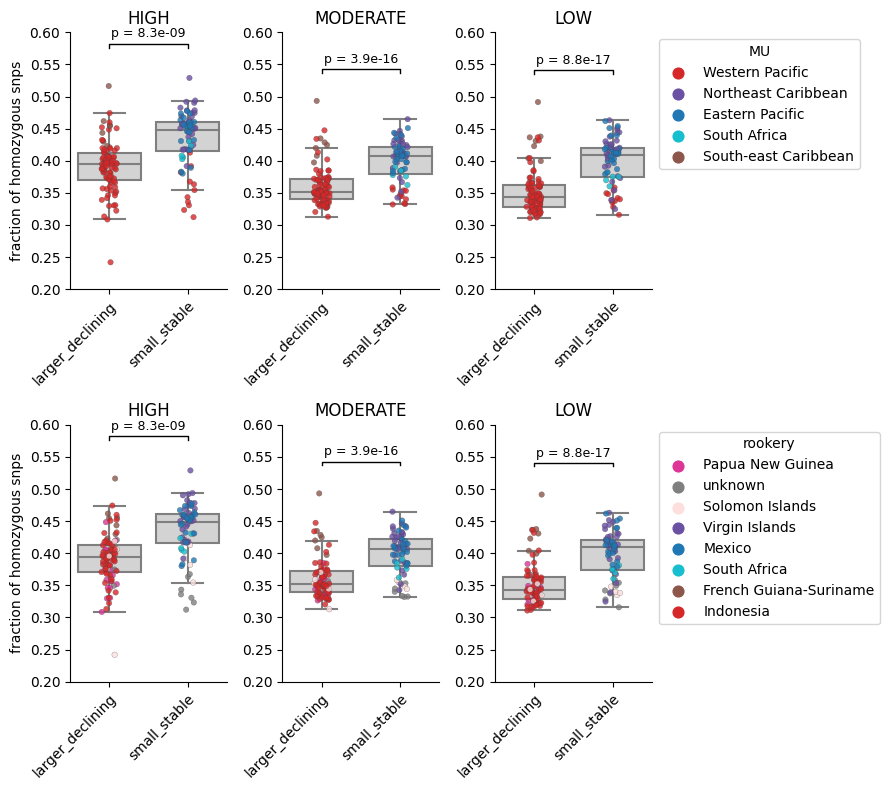

In [99]:
groups = ['MU', 'rookery']
impacts = ['HIGH', 'MODERATE', 'LOW']
variant = 'snps'
state = 'hom'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]

fig, axes = plt.subplots(2, 3, figsize = (9, 8))

for j in range(len(groups)):
    for i in range(len(impacts)):
        axi = axes[j][i]
        impact = impacts[i]
        
        dfi = df_all[(df_all['variant'] == variant) & (df_all['state'] == state)]
        dfi = dfi[dfi['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1]['number']
        data2 = dfi[dfi['group'] == g2]['number']

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
        
        sns.boxplot(ax=axi, data=dfi, x='group', y='fraction', order=pop_order,
                    showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='fraction', hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('fraction of homozygotes in {}'.format(impact))
        axi.set_xlabel('')
        axi.set_ylim(0.2, 0.6)
        
        # Add bar and p-value
        y_max = max(dfi['fraction']) * 1.1
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.1e}", ha='center', va='bottom', fontsize=9)
        
        axi.set_title(f'{impact}')
        if i == 0:    
            axi.set_ylabel('fraction of homozygous snps')
            axi.get_legend().set_visible(False)
        else:
            axi.set_ylabel('')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## 1.7. To check distnace to ref, plot both 0/0 (ref) and 1/1 (alt) homozygotes

In [115]:
## Read summary file with total number of variants by impact
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_out/all_samples.hom_het_by_impact.ref_alt.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

sample    impact    state  number country  year  depth
0  dc_100028_bb_noq      HIGH  hom_ref   27681  Mexico  2016  14.38
1  dc_100028_bb_noq  MODERATE  hom_ref   41419  Mexico  2016  14.38
2  dc_100028_bb_noq       LOW  hom_ref   37742  Mexico  2016  14.38

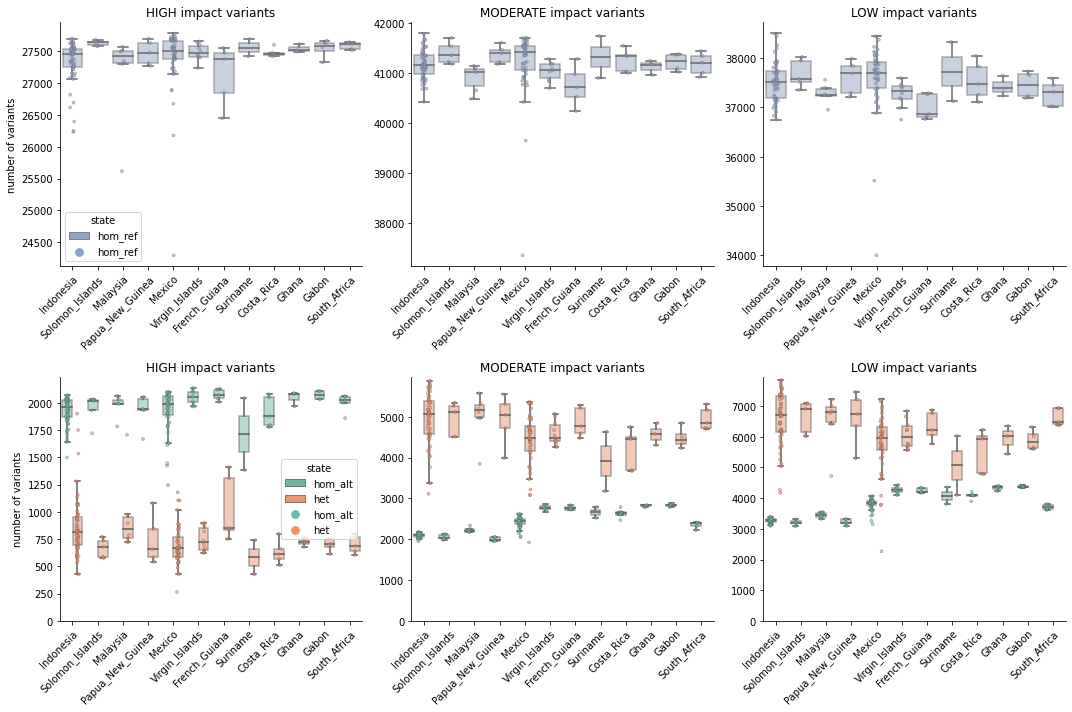

In [116]:
impacts = ['HIGH', 'MODERATE', 'LOW']
fig, axes = plt.subplots(2, 3, figsize = (15, 10))
pal = sns.color_palette('Set2')

for i in range(len(impacts)):
    impact = impacts[i]
    for j in range(2):
        if j == 0:
            ## homozygotes ref
            p = pal[2:3]
            axi = axes[j][i]
            dfi = df_all[(df_all['impact'] == impact) & (df_all['state'] == 'hom_ref')]
        else:
            ## homozygotes alt and heterogygotes
            p = pal[:2]
            axi = axes[j][i]
            dfi = df_all[(df_all['impact'] == impact) & (df_all['state'] != 'hom_ref')]

        sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                    palette=p, showfliers=False, boxprops=dict(alpha=0.5))
        sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                      palette=p, alpha=0.6, s=3, dodge=True, linewidth=0.5)


        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('{} impact variants'.format(impact))
        axi.set_xlabel('')
        if j != 0:
            axi.set_ylim(0, max(dfi['number']) + 100)
        if i == 0:
            axi.set_ylabel('number of variants')
        else:
            axi.set_ylabel('')
            axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 1.8 ANNOVAR annotation!

In [101]:
dc = '222'
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = f'ANNOVAR_{dc}/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df = df[df['state'] != 'hom_ref']

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all['exclude'] = df_all['exclude'].fillna('include')
df_all.head(3)

sample    impact state  number variant             rookery    year  \
0  Z005878      HIGH   hom      28    snps  Pacific Costa Rica  1994.0   
1  Z005878  MODERATE   hom    2425    snps  Pacific Costa Rica  1994.0   
2  Z005878       LOW   hom    4792    snps  Pacific Costa Rica  1994.0   

              group               MU  depth  exclude               batch  
0  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
1  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
2  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR

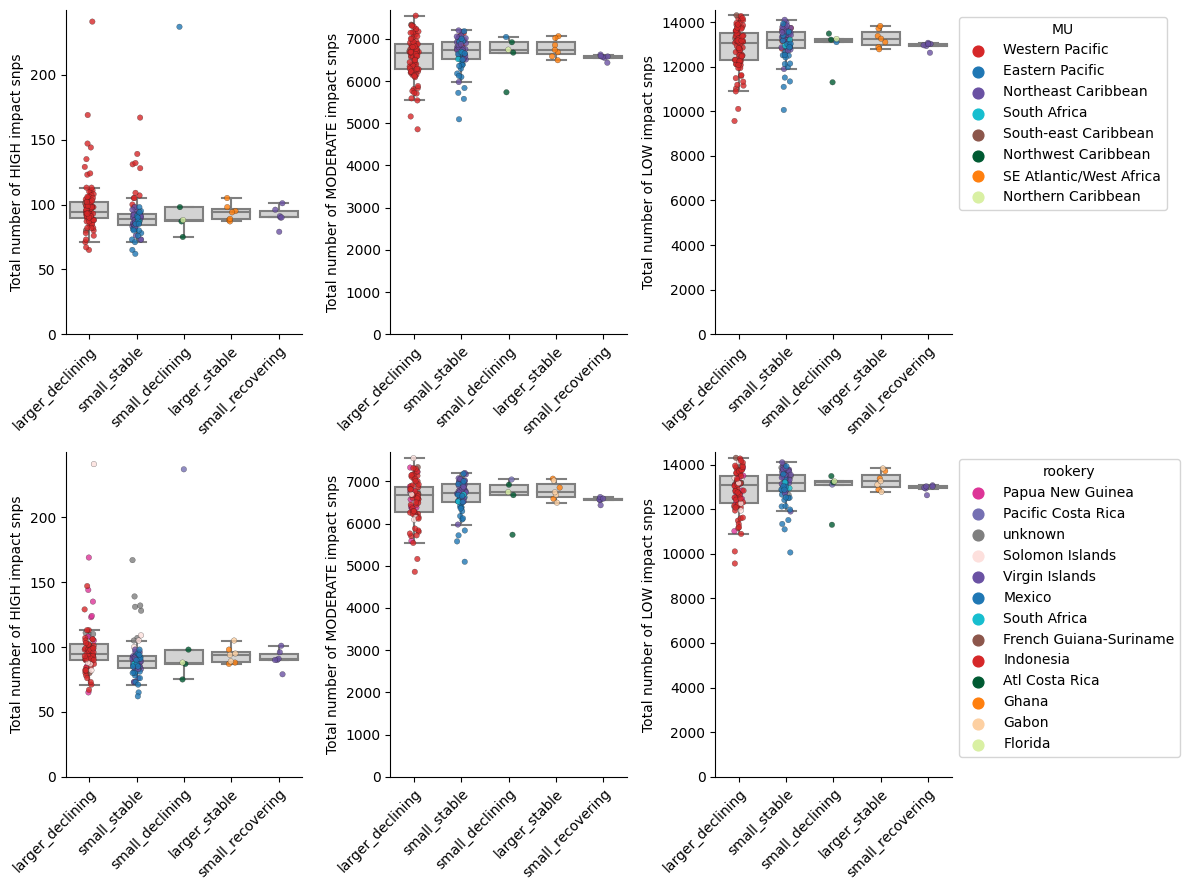

In [110]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'rookery', 'year', 'group', 'exclude', 'batch']).sum().reset_index()

# Exclude 'MODIFIER' snps
grouped_df = grouped_df[grouped_df['impact'] != 'MODIFIER']
impacts = ['HIGH', 'MODERATE', 'LOW']

fig, axes = plt.subplots(2, 3, figsize=(12, 9))

groups = ['MU', 'rookery']

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]
        p = color_dict[group]

        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, 
                    color="lightgrey", order=pop_order)
        sns.stripplot(ax=axi, data=dfi, x='group', y='number',  hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact snps')
        axi.set_xlabel('')
        axi.set_ylim(0, None)
        
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

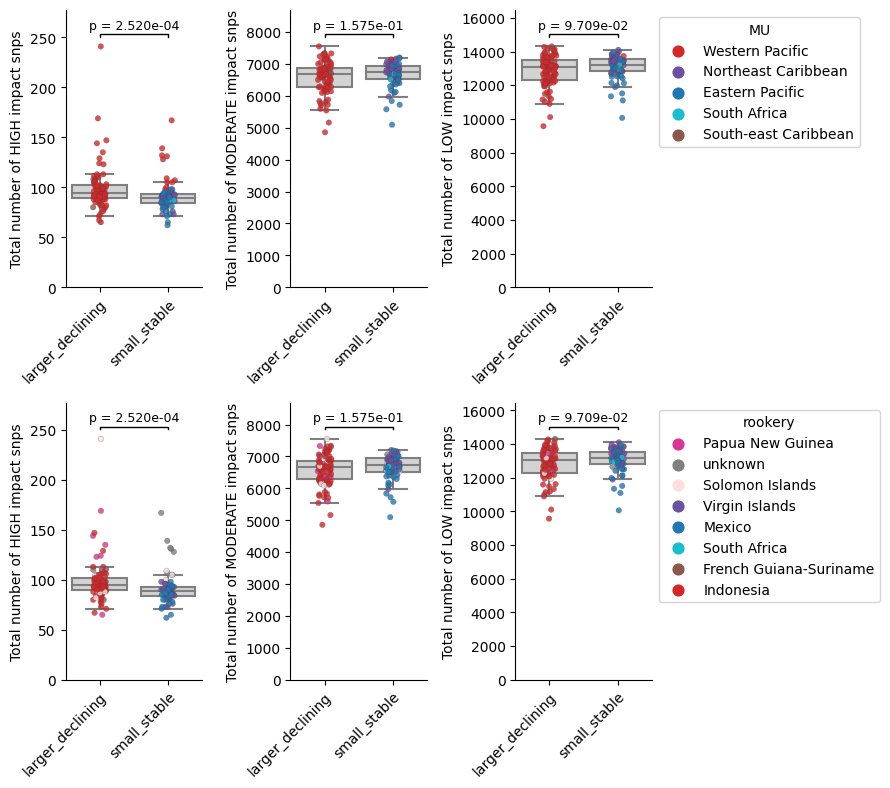

In [113]:
impacts = ['HIGH', 'MODERATE', 'LOW']
groups = ['MU', 'rookery']
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]

fig, axes = plt.subplots(2, 3, figsize=(9, 8))

for j in range(len(groups)):
    for i, impact in enumerate(impacts):
   
        axi = axes[j, i]
        dfi = grouped_df[grouped_df['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1]['number']
        data2 = dfi[dfi['group'] == g2]['number']

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
    
        sns.boxplot(ax=axi, data=dfi, x='group', y='number', showfliers=False, 
                    color="lightgrey", order=pop_order)
        sns.stripplot(ax=axi, data=dfi, x='group', y='number',  hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'Total number of {impact} impact snps')
        axi.set_xlabel('')
        axi.set_ylim(0, max(dfi['number'])*1.15)
        
        # Add bar and p-value
        y_max = max(dfi['number']) * 1.05        
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=9)
        
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## 1.9. Plot fraction of homozygots per impact: ANNOVAR

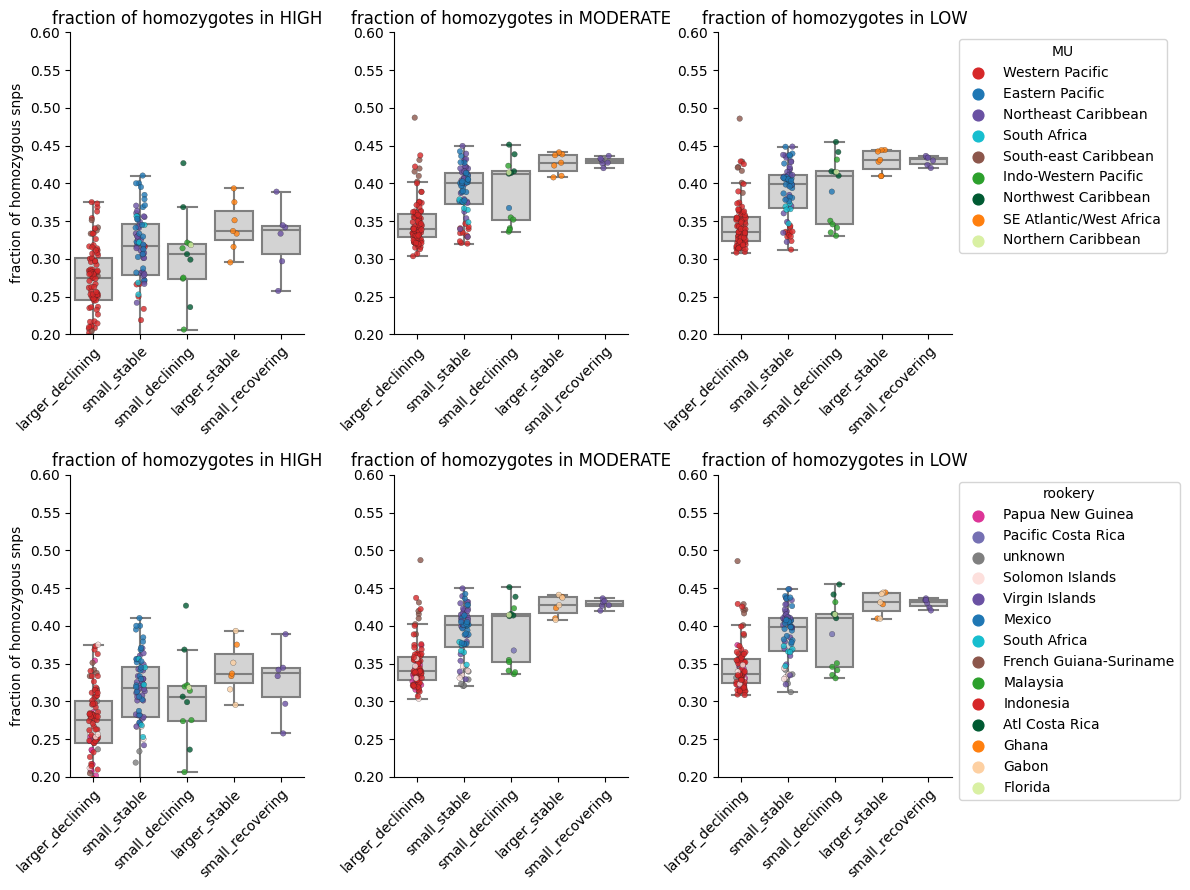

In [103]:
totals = df_all.groupby(["sample", "impact", "variant", "rookery"])["number"].transform("sum")
df_all["fraction"] = df_all["number"] / totals

groups = ['MU', 'rookery']
impacts = ['HIGH', 'MODERATE', 'LOW']
variant = 'snps'
state = 'hom'

fig, axes = plt.subplots(2, 3, figsize = (12, 9))

for j in range(len(groups)):
    for i in range(len(impacts)):
        axi = axes[j][i]
        impact = impacts[i]
        group = groups[j]
        p = color_dict[group]
        
        dfi = df_all[(df_all['variant'] == variant) & (df_all['state'] == state)]
        dfi = dfi[dfi['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']

        sns.boxplot(ax=axi, data=dfi, x='group', y='fraction', order=pop_order,
                    showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='fraction', hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('fraction of homozygotes in {}'.format(impact))
        axi.set_xlabel('')
        axi.set_ylim(0.2, 0.6)
        
        if i == 0:    
            axi.set_ylabel('fraction of homozygous snps')
            axi.get_legend().set_visible(False)
        else:
            axi.set_ylabel('')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

## Plot main groups only

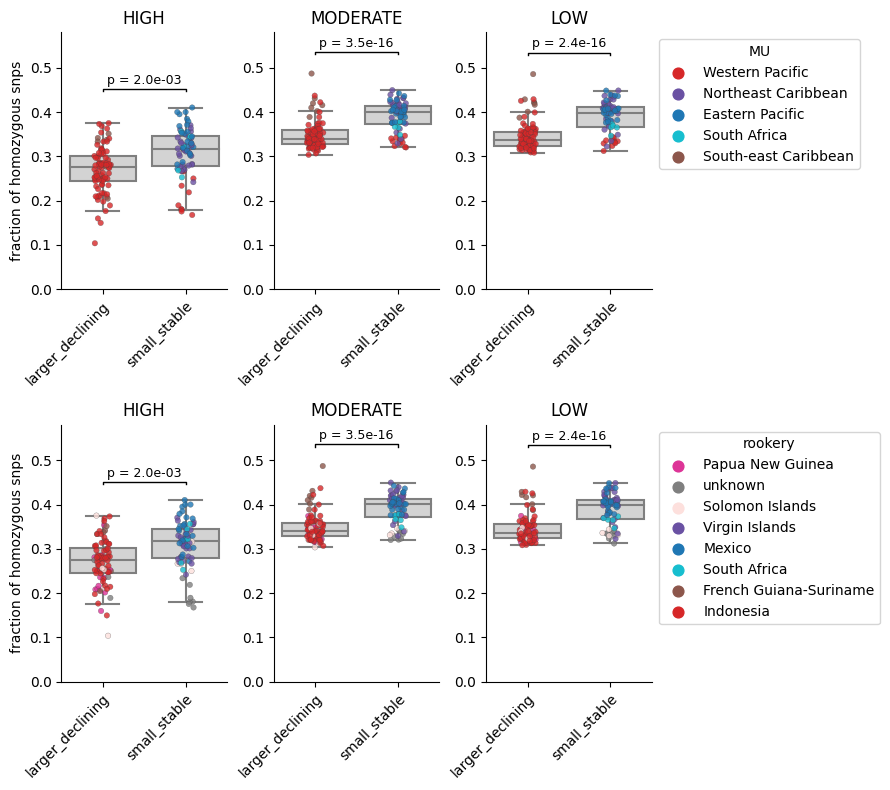

In [108]:
groups = ['MU', 'rookery']
impacts = ['HIGH', 'MODERATE', 'LOW']
variant = 'snps'
state = 'hom'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]

fig, axes = plt.subplots(2, 3, figsize = (9, 8))

for j in range(len(groups)):
    for i in range(len(impacts)):
        axi = axes[j][i]
        impact = impacts[i]
        
        dfi = df_all[(df_all['variant'] == variant) & (df_all['state'] == state)]
        dfi = dfi[dfi['impact'] == impact]
        dfi = dfi[dfi['exclude'] == 'include']
        dfi = dfi[dfi['group'].isin(pops)]
        
        group = groups[j]
        p = color_dict[group]

        # Subset data per population
        data1 = dfi[dfi['group'] == g1]['number']
        data2 = dfi[dfi['group'] == g2]['number']

        # Perform Mann–Whitney U test
        stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
        
        sns.boxplot(ax=axi, data=dfi, x='group', y='fraction', order=pop_order,
                    showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='fraction', hue=group, order=pop_order,
                      alpha=0.8, s=4, linewidth=0.2, palette=p)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('fraction of homozygotes in {}'.format(impact))
        axi.set_xlabel('')
        axi.set_ylim(0, 0.58)
        
        # Add bar and p-value
        y_max = max(dfi['fraction']) * 1.1
        axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
        axi.text(0.5, y_max * 1.01, f"p = {pval:.1e}", ha='center', va='bottom', fontsize=9)
        
        axi.set_title(f'{impact}')
        if i == 0:    
            axi.set_ylabel('fraction of homozygous snps')
            axi.get_legend().set_visible(False)
        else:
            axi.set_ylabel('')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

# 2. Temporal analysis. Mexico, Indonesia, and US Virgin Islands samples

## 2.1. Plot number of variants for 3 (Mexico), 6 (Indonesia), and 7 (US Virgin Islands)  timepoints

In [21]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'snpEff_out/all_samples.hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

sample    impact state  number country  year  depth  \
0  dc_100028_bb_noq      HIGH   hom    2074  Mexico  2016  14.38   
1  dc_100028_bb_noq  MODERATE   hom    2524  Mexico  2016  14.38   
2  dc_100028_bb_noq       LOW   hom    4073  Mexico  2016  14.38   

           grouping  
0  small_recovering  
1  small_recovering  
2  small_recovering

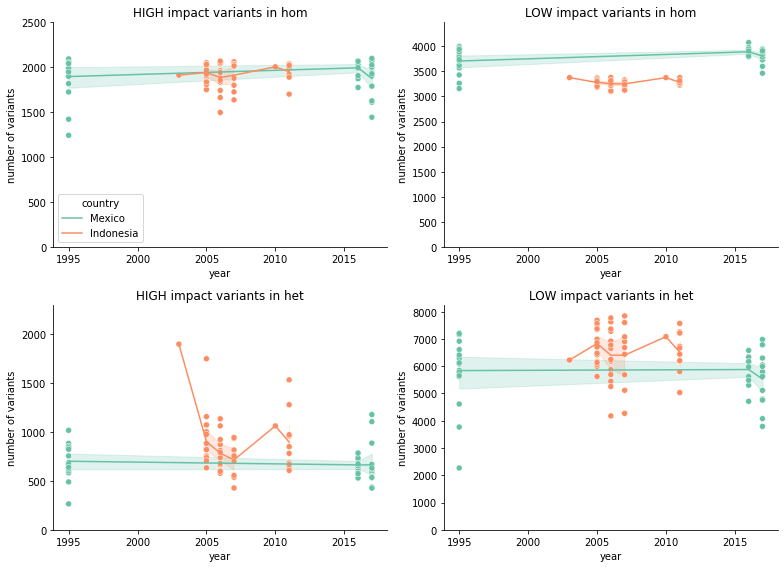

In [22]:
countries = ['Indonesia', 'Mexico', 'Virgin_Islands']
df_temporal = df_all[df_all['country'].isin(countries)].dropna()
df_temporal['year'] = pd.to_numeric(df_temporal['year'])

impacts = ['HIGH', 'LOW']
states = ['hom', 'het']

sns.set_palette('Set2')
fig, axes = plt.subplots(2, 2, figsize = (11, 8))


for i in range(4):
    j = i % 2
    k = i // 2
    axi = axes[j][k]
    impact = impacts[k]
    state = states[j]
    dfi = df_temporal[(df_temporal['impact'] == impact) & (df_temporal['state'] == state)]
    
    sns.lineplot(ax=axi, data=dfi, x='year', y='number', hue='country', marker='', ci=95)
    sns.scatterplot(ax=axi, data=dfi, x='year', y='number', hue='country', legend=False, markers=True)

    axi.set_ylim(0, max(dfi['number']) + 400)
    axi.set_title('{} impact variants in {}'.format(impact, state))
    axi.set_ylabel('number of variants')
    if i != 0:
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# 3. ROH analysis

## 3.1. ROH analysis with PLINK

In [123]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'ROH_222/all_samples_binned_ROH.tsv'
file_data = glob(dir_path + file_name)[0]
df_roh = pd.read_csv(file_data, sep='\t')
df_roh['L_total'] = df_roh['L_less100'] + df_roh['L_100_500'] + df_roh['L_more500']
df_roh['L_less500'] = df_roh['L_total'] - df_roh['L_100_500']
df_roh['L_ave'] = df_roh['L_total'] / df_roh['number_ROH']

## Assign location to each sample
df_all_roh = pd.merge(df_roh, INFO, on='sample')

df_all_roh['exclude'] = df_all_roh['exclude'].fillna('include')
df_all_roh.head(3)

sample                round  number_ROH   L_less100   L_100_500  \
0  Z005878  from_Lisa_window_20       10232  390751.609  835036.509   
1  Z005882  from_Lisa_window_20        7905  287180.462  693287.245   
2  Z005883  from_Lisa_window_20        7835  290399.621  666386.198   

   L_more500      L_total   L_less500       L_ave             rookery    year  \
0  78925.356  1304713.474  469676.965  127.513045  Pacific Costa Rica  1994.0   
1  70653.806  1051121.513  357834.268  132.969198  Pacific Costa Rica  1994.0   
2  86163.234  1042949.053  376562.855  133.114110  Pacific Costa Rica  1994.0   

              group               MU  depth  exclude               batch  
0  larger_declining  Eastern Pacific   6.22  exclude  novo42_Illumina_SR  
1  larger_declining  Eastern Pacific  10.18  exclude  novo42_Illumina_SR  
2  larger_declining  Eastern Pacific  10.91  exclude  novo42_Illumina_SR

### 3.1.1. Plot correlation with depth: total number of ROH, total length of ROH, and average length of ROH with a fixed sliding window = 20 
### => no correlation!           outlier sample: dc_11121_bb_noq

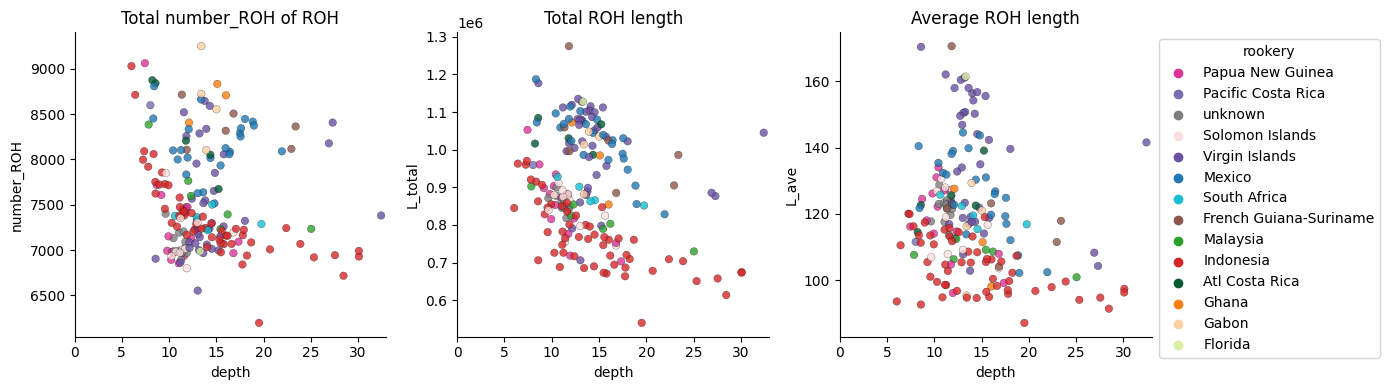

In [124]:
fig, axes = plt.subplots(1, 3, figsize = (14, 4))

q = 20
round_q = 'from_Lisa_window_{}'.format(q)
values = ['number_ROH', 'L_total', 'L_ave']
group = 'rookery'

for i in range(3):
    axi = axes[i]
    v = values[i]
    dfi = df_all_roh[df_all_roh['round'] == round_q]
    dfi = dfi[dfi['exclude'] == 'include']
    
    sns.scatterplot(ax=axi, data=dfi, x='depth', y=v, hue=group, 
                    alpha=0.8, edgecolor='k', s=30, linewidth=0.2, palette=p)
    axi.set(xlim=(0, 33))
    
    if i == 0:
        axi.set_title('Total {} of ROH'.format(v))
    elif i == 1:
        axi.set_title('Total ROH length')
    else:
        axi.set_title('Average ROH length')
    if i != 2:
        axi.get_legend().set_visible(False)
    else:
        sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### 3.1.2. Plot binned ROH for different sliding window sizes: Mexico samples
### relative ROH across samples stays consistent except for the same outlier: dc_11121_bb_noq

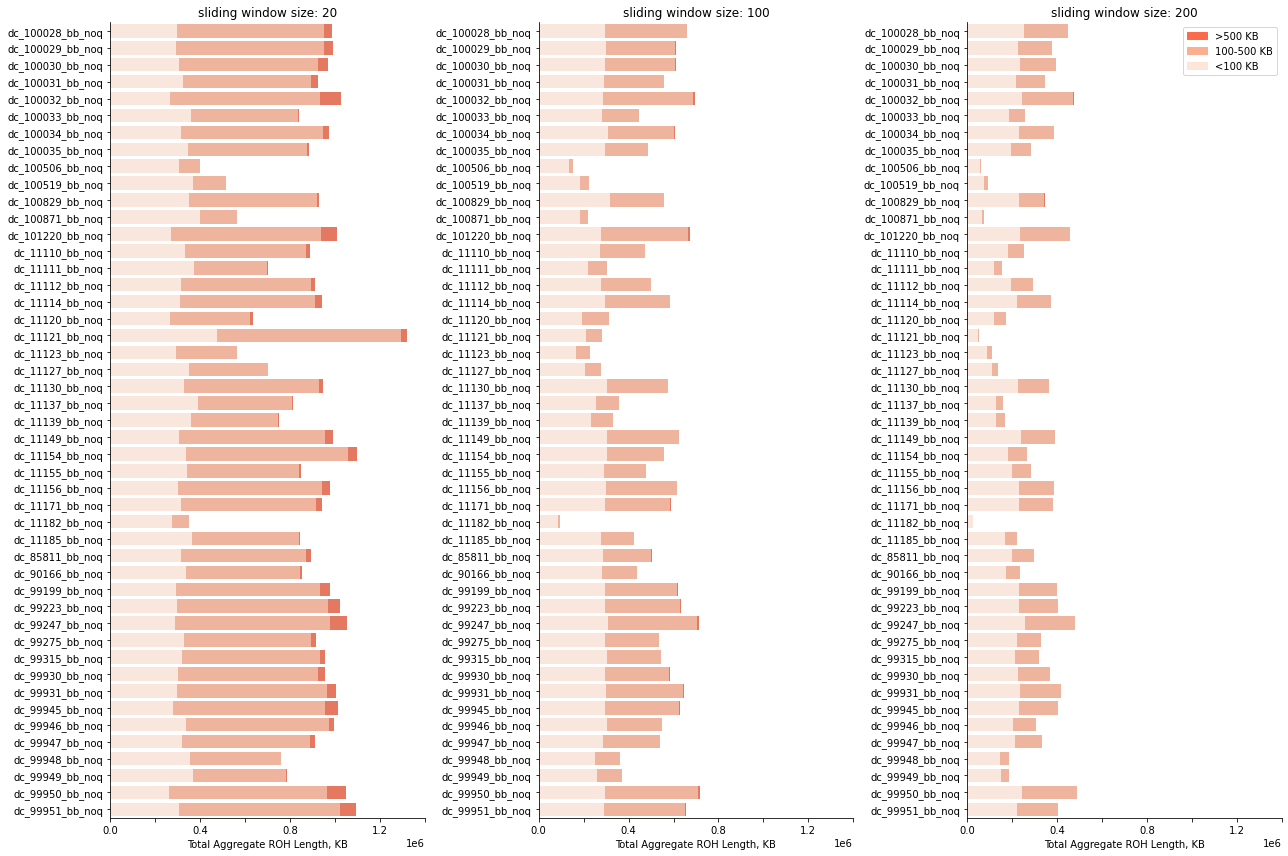

In [31]:
q_values = [20, 100, 200]
p = sns.color_palette(['#fee5d9', '#fcae91', '#fb6a4a', '#cb181d'])

fig, axes = plt.subplots(1, 3, figsize = (18, 12))

for i in range(3):
    axi = axes[i]
    q = q_values[i]
    round_q = 'from_Lisa_window_{}'.format(q)
    dfi = df_all_roh[(df_all_roh['round'] == round_q) & (df_all_roh['country'] == 'Mexico')]
    
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_total', color=p[2])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less500', color=p[1])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less100', color=p[0])
    
    axi.set(title='sliding window size: {}'.format(q), 
            xlabel='Total Aggregate ROH Length, KB',
            ylabel='', 
            xlim=(0, 1_400_000))
    
    labels = axi.get_xticklabels()
    for x, label in enumerate(labels):
        if x % 2 == 1:
            label.set_visible(False)

            
# add custom legend
bin1 = mpatches.Patch(color=p[2], label='>500 KB')
bin2 = mpatches.Patch(color=p[1], label='100-500 KB')
bin3 = mpatches.Patch(color=p[0], label='<100 KB')
plt.legend(handles=[bin1, bin2, bin3], loc="upper right")

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### 3.1.3. Plot binned ROH for 3 rounds running PLINK: Mexico samples

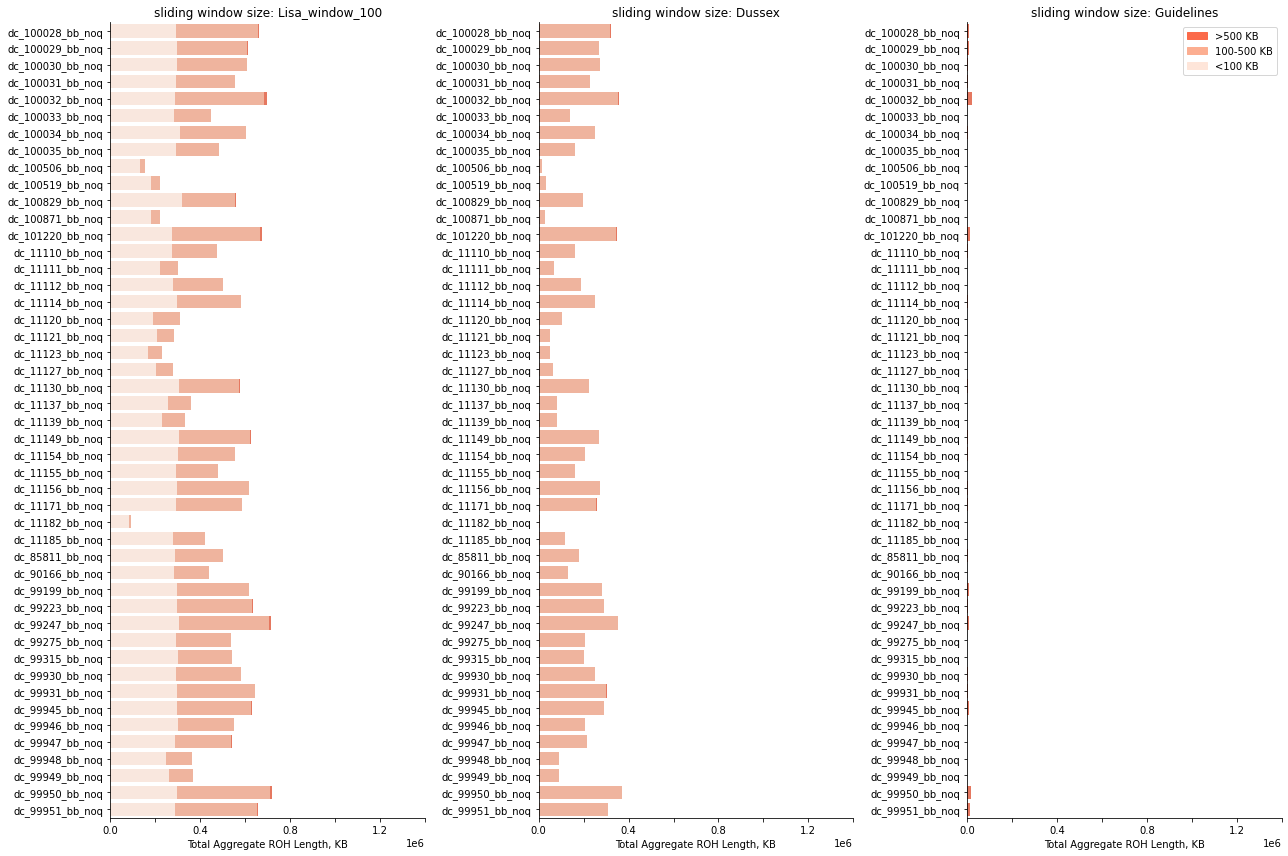

In [32]:
q_values = ['Lisa_window_100', 'Dussex', 'Guidelines']
p = sns.color_palette(['#fee5d9', '#fcae91', '#fb6a4a', '#cb181d'])

fig, axes = plt.subplots(1, 3, figsize = (18, 12))

for i in range(3):
    axi = axes[i]
    q = q_values[i]
    round_q = 'from_{}'.format(q)
    dfi = df_all_roh[(df_all_roh['round'] == round_q) & (df_all_roh['country'] == 'Mexico')]
    
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_total', color=p[2])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less500', color=p[1])
    sns.barplot(ax=axi, data=dfi, y='sample', x='L_less100', color=p[0])
    
    axi.set(title='sliding window size: {}'.format(q), 
            xlabel='Total Aggregate ROH Length, KB',
            ylabel='', 
            xlim=(0, 1_400_000))
    
    labels = axi.get_xticklabels()
    for x, label in enumerate(labels):
        if x % 2 == 1:
            label.set_visible(False)
            
# add custom legend
bin1 = mpatches.Patch(color=p[2], label='>500 KB')
bin2 = mpatches.Patch(color=p[1], label='100-500 KB')
bin3 = mpatches.Patch(color=p[0], label='<100 KB')
plt.legend(handles=[bin1, bin2, bin3], loc="upper right")

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### 3.1.4 Calculate F_ROH (inbreeding coefficient) with PLINK and from_Lisa_window_20 parameters|

In [126]:
## Calculate F_ROH = L_ROH/Lgenome, in kb!!
L_genome = 2_164_762.090
df_all_roh['F_ROH'] = df_all_roh['L_total'] / L_genome

q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_roh = df_all_roh[df_all_roh['round'] == round_q][['sample', 'F_ROH', 'number_ROH']]

## Merge with snpEff data - make sure df_all is from snpEff!
df_roh_merged = pd.merge(df_roh, df_all, on='sample')
df_roh_merged.head()

sample     F_ROH  number_ROH    impact state  number variant  \
0  Z005878  0.602705       10232      HIGH   hom     125    snps   
1  Z005878  0.602705       10232  MODERATE   hom    2697    snps   
2  Z005878  0.602705       10232       LOW   hom    3352    snps   
3  Z005878  0.602705       10232  MODIFIER   hom  439935    snps   
4  Z005878  0.602705       10232      HIGH   het     218    snps   

              rookery    year             group               MU  depth  \
0  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
1  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
2  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
3  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
4  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   

   exclude               batch  
0  exclude  novo42_Illumina_SR  
1  exclude  novo42_Illumina_SR  
2  exclude  novo42_Illumina_SR  
3  exclude  novo42_Illumina_SR  
4  exclude  novo42_Illumina_SR

### 3.1.5. Plot L_ROH = f(F_ROH)

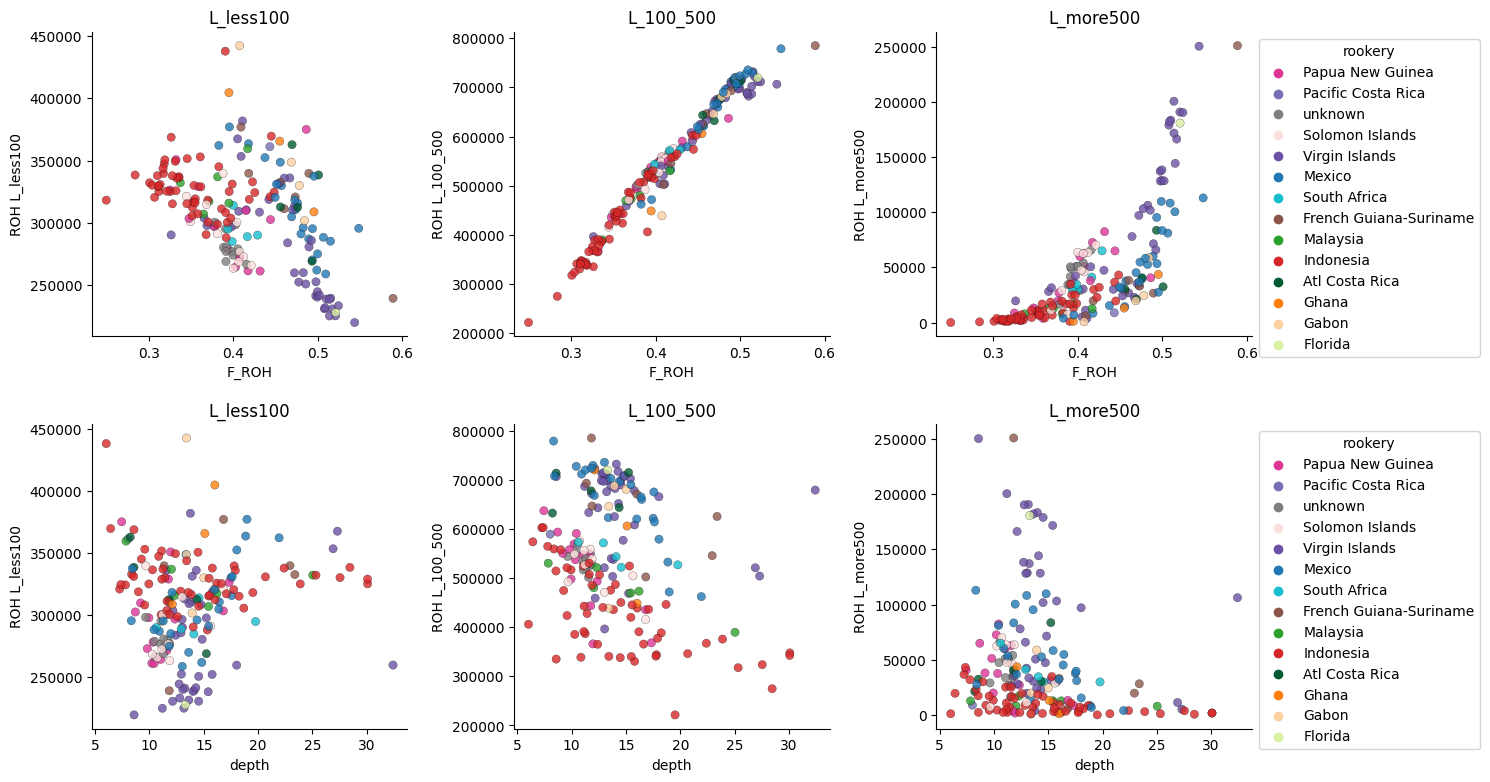

In [136]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
p = color_dict['rookery']

## select only one round of PLINK ROH params
q = 20
round_q = 'from_Lisa_window_{}'.format(q)
df_temp = df_all_roh[df_all_roh['round'] == round_q]
df_temp = df_temp[df_temp['exclude'] == 'include']

values = ['L_less100', 'L_100_500', 'L_more500']
x_values = ['F_ROH', 'depth']

for i in range(len(values)):
    for j in range(len(x_values)):
        axi = axes[j][i]
        v = values[i]
        x = x_values[j]

        sns.scatterplot(ax=axi, data=df_temp, x=x, y=v, hue=group, 
                        alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)

        axi.set_title(v)
        axi.set_ylabel(f'ROH {v}')
        axi.set_xlabel(x)
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### Plot main groups only

In [145]:
values = ['L_less100', 'L_100_500', 'L_more500', 'L_total', 'number_ROH']
pvals = []
value_stats = []

# Step 1: Collect all p-values
for v in values:
    dfi = df_temp[df_temp['group'].isin(pops)]
    data1 = dfi[dfi['group'] == g1][v]
    data2 = dfi[dfi['group'] == g2][v]
    
    # Mann–Whitney U test
    stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
    pvals.append(pval)
    value_stats.append((v, stat))

# FDR correction
rej, qvals, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Zip them together
value_to_qval = {v: q for (v, _), q in zip(value_stats, qvals)}

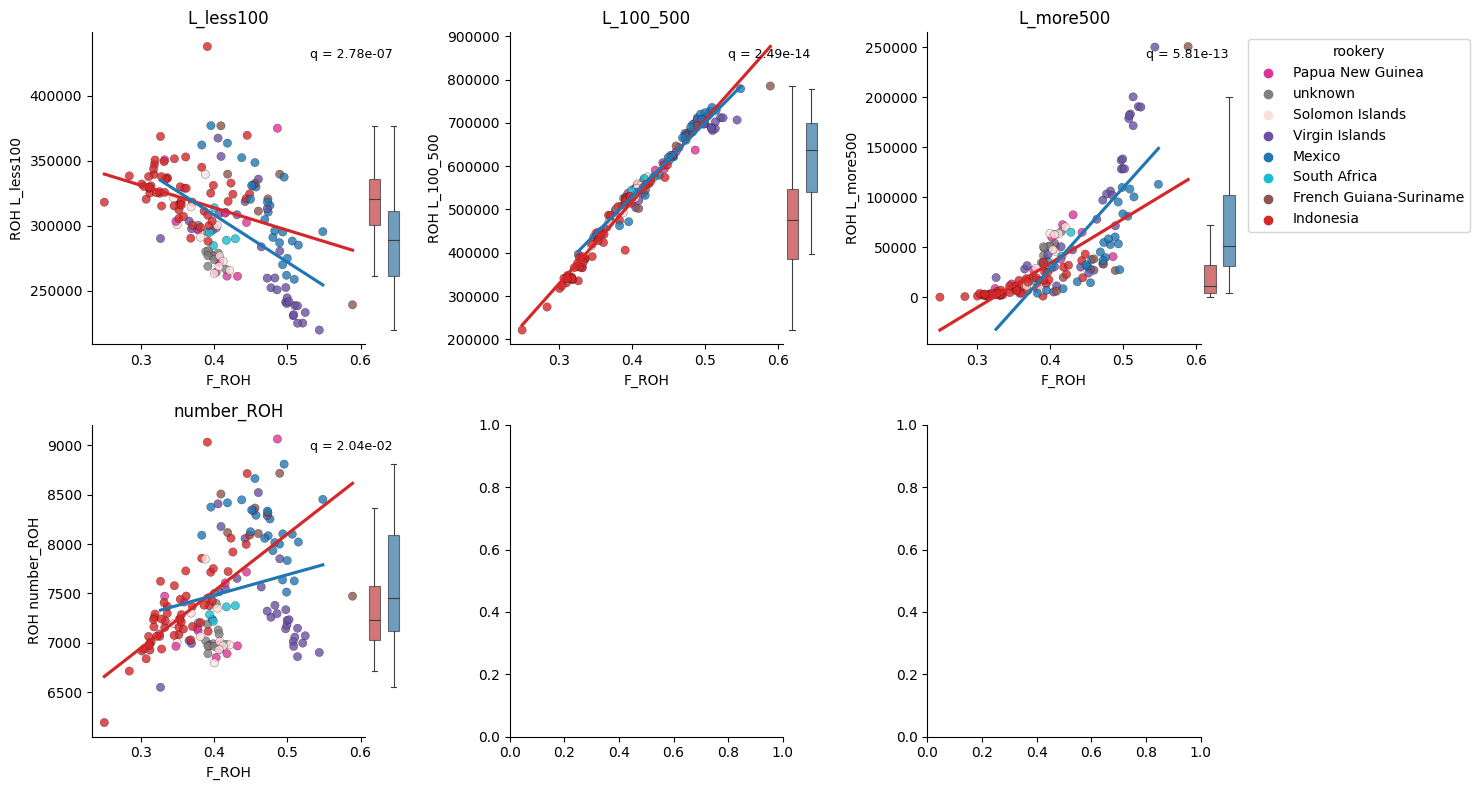

In [147]:
values = ['L_less100', 'L_100_500', 'L_more500', 'number_ROH']
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
group = 'rookery'
x = 'F_ROH'

# define colors
p = color_dict[group]
p0 = color_dict['pops']
c1 = p0[g1]
c2 = p0[g2]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for k in range(len(values)):
    i = k % 3
    j = k // 3
    v = values[k]
    ax_main = axes[j][i]

    dfi = df_temp[df_temp['group'].isin(pops)]

    # Scatterplot + regression lines
    sns.regplot(ax=ax_main, data=dfi[dfi['group'] == g1], x=x, y=v, scatter=False, color=c1, ci=None)
    sns.regplot(ax=ax_main, data=dfi[dfi['group'] == g2], x=x, y=v, scatter=False, color=c2, ci=None)
    
    sns.scatterplot(ax=ax_main, data=dfi, x=x, y=v, hue=group, 
                    alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)
    
    ax_main.set_title(v)
    ax_main.set_xlabel(x)
    ax_main.set_ylabel(f'ROH {v}')

    # Add tiny boxplot inset
    inset_width = 0.14
    inset_height = 1
    ax_inset = ax_main.inset_axes([1, 0, inset_width, inset_height])  # [x0, y0, width, height]

    sns.boxplot(ax=ax_inset, data=dfi, y=v, x='group', boxprops=dict(alpha=.7),
                width=0.6, fliersize=0, linewidth=0.8, palette=p0)

    # Cleanup inset axis
    ax_inset.set_xticks([])
    ax_inset.set_xlabel('')
    ax_inset.set_ylabel('')
    ax_inset.set_yticks([])
    ax_inset.set_frame_on(False)

    # Match y-axis range to main axis for alignment
    ax_inset.set_ylim(ax_main.get_ylim())

    # Add FDR above the plot
    qval = value_to_qval[v]
    ax_main.text(0.95, 0.95, f"q = {qval:.2e}", ha='center', va='top',
                 fontsize=9, transform=ax_main.transAxes)
    # Legend
    if i != 2:
        ax_main.get_legend().set_visible(False)
    else:
        sns.move_legend(ax_main, "upper left", bbox_to_anchor=(1.15, 1))

sns.despine()
fig.tight_layout()

### Plot F_ROH only

In [164]:
df_roh_merged.head(10)

sample     F_ROH  number_ROH    impact state  number variant  \
0  Z005878  0.602705       10232      HIGH   hom     125    snps   
1  Z005878  0.602705       10232  MODERATE   hom    2697    snps   
2  Z005878  0.602705       10232       LOW   hom    3352    snps   
3  Z005878  0.602705       10232  MODIFIER   hom  439935    snps   
4  Z005878  0.602705       10232      HIGH   het     218    snps   
5  Z005878  0.602705       10232  MODERATE   het    3733    snps   
6  Z005878  0.602705       10232       LOW   het    4460    snps   
7  Z005878  0.602705       10232  MODIFIER   het  476410    snps   
8  Z005882  0.485560        7905      HIGH   hom     137    snps   
9  Z005882  0.485560        7905  MODERATE   hom    2914    snps   

              rookery    year             group               MU  depth  \
0  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
1  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
2  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
3  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
4  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
5  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
6  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
7  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific   6.22   
8  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific  10.18   
9  Pacific Costa Rica  1994.0  larger_declining  Eastern Pacific  10.18   

   exclude               batch  
0  exclude  novo42_Illumina_SR  
1  exclude  novo42_Illumina_SR  
2  exclude  novo42_Illumina_SR  
3  exclude  novo42_Illumina_SR  
4  exclude  novo42_Illumina_SR  
5  exclude  novo42_Illumina_SR  
6  exclude  novo42_Illumina_SR  
7  exclude  novo42_Illumina_SR  
8  exclude  novo42_Illumina_SR  
9  exclude  novo42_Illumina_SR

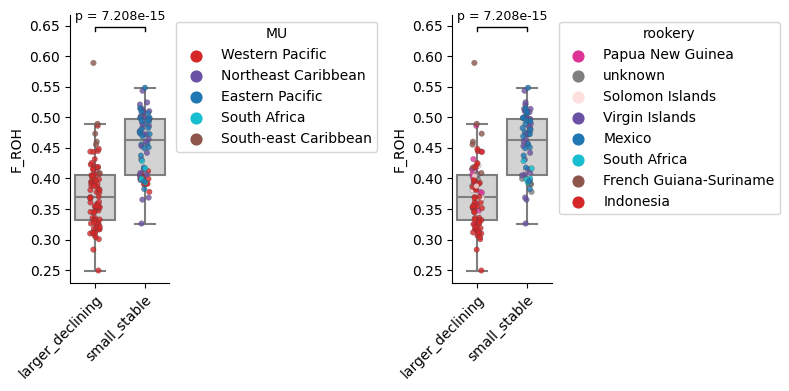

In [166]:
groups = ['MU', 'rookery']
variant = 'snps'
g1 = 'larger_declining'
g2 = 'small_stable'
pops = [g1, g2]
y = 'F_ROH'

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for j in range(len(groups)):
    axi = axes[j]
    dfi = df_temp[df_temp['variant'] == variant]
    dfi = dfi[dfi['exclude'] == 'include']
    dfi = dfi[dfi['group'].isin(pops)]
    dfi = dfi[['sample', 'F_ROH', 'group'] + groups].drop_duplicates()

    group = groups[j]
    p = color_dict[group]

    # Subset data per population
    data1 = dfi[dfi['group'] == g1][y]
    data2 = dfi[dfi['group'] == g2][y]

    # Perform Mann–Whitney U test
    stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')

    sns.boxplot(ax=axi, data=dfi, x='group', y=y, showfliers=False, color="lightgrey")
    sns.stripplot(ax=axi, data=dfi, x='group', y=y, hue=group, 
                  alpha=0.8, s=4, linewidth=0.2, palette=p)

    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
#     axi.set_ylabel(f'number of {variant}, per Mb')
    axi.set_xlabel('')
#     axi.set_ylim(400, 800)

    # Add bar and p-value
    y_max = max(dfi[y]) * 1.1
    axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
    axi.text(0.5, y_max * 1.01, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=9)

    sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### Plot number of homozygotes by impact as a function of inbreeding coefficient (F_ROH)
#### Consider only SNPs (exclude indels)

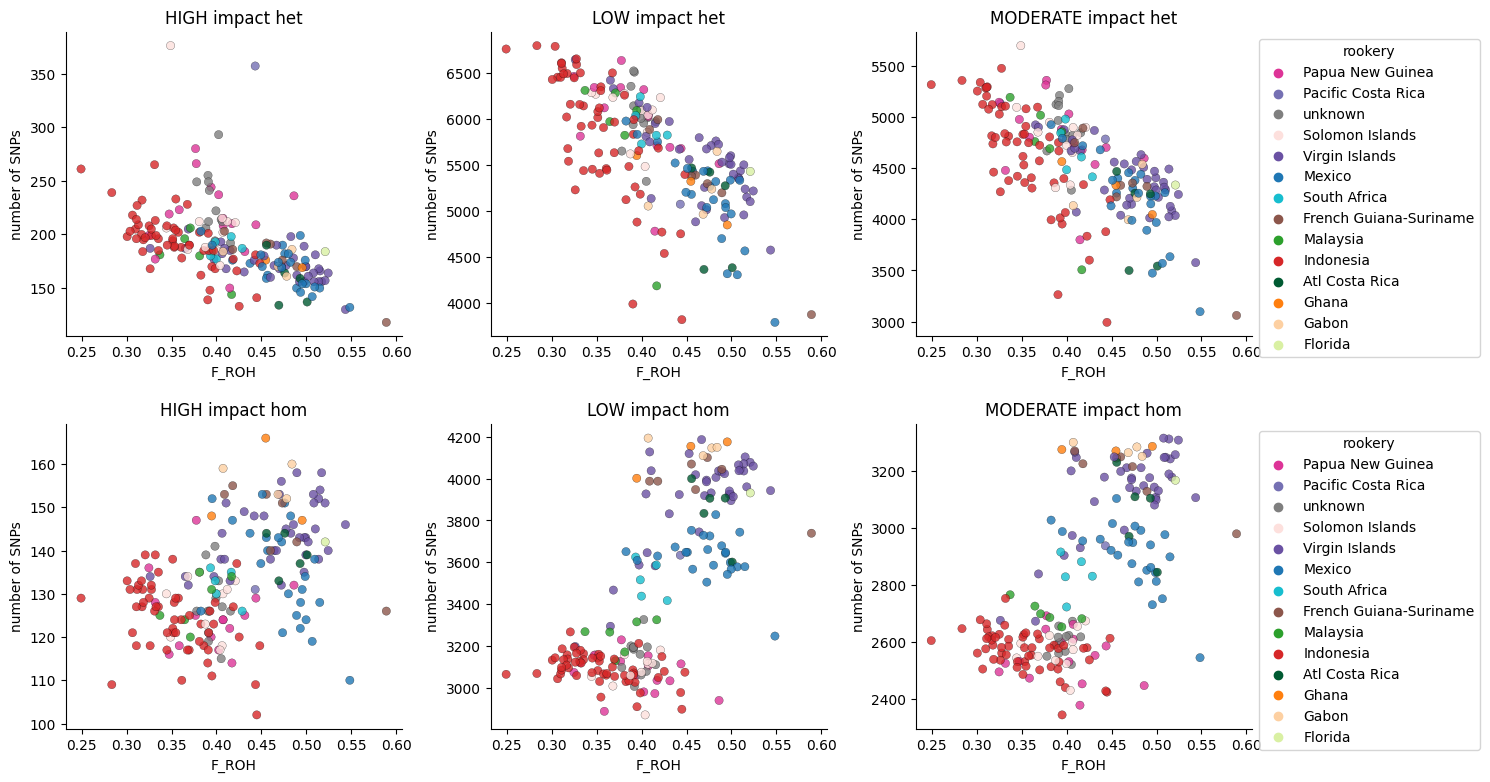

In [155]:
var = 'snps'
x = 'F_ROH'
v = 'number'
df_temp = df_roh_merged[(df_roh_merged['variant'] == var)]
df_temp = df_temp[df_temp['exclude'] == 'include']

states = list(set(df_temp['state']))
impacts = list(set(df_temp['impact']) - set(['MODIFIER']))

fig, axes = plt.subplots(2, 3, figsize = (15, 8))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        axi = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

        sns.scatterplot(ax=axi, data=dfi, x=x, y=v, hue=group, 
                        alpha=0.8, edgecolor='k', linewidth=0.2, palette=p)
        
        axi.set_title('{} impact {}'.format(impact, state))
        axi.set_ylabel('number of SNPs')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

### Plot main groups only

### 3.1.6. ROH = f(t) Mexico, Indonesia, and USVI

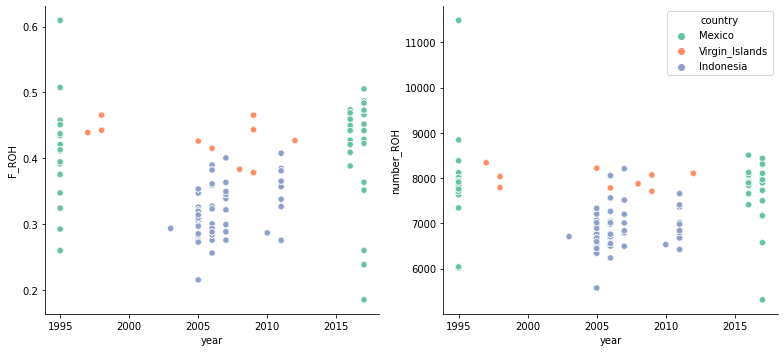

In [42]:
countries = ['Indonesia', 'Mexico', 'Virgin_Islands']
df_temporal = df_roh_merged[df_roh_merged['country'].isin(countries)].dropna()
df_temporal['year'] = pd.to_numeric(df_temporal['year'])

rohs = ['F_ROH', 'number_ROH']

sns.set_palette('Set2')
fig, axes = plt.subplots(1, 2, figsize = (11, 5))


for i in range(2):
    axi = axes[i]
    roh = rohs[i]

    dfi = df_temporal
#     sns.lineplot(ax=axi, data=dfi, x='year', y=roh, hue='country', marker='', ci=95)
    sns.scatterplot(ax=axi, data=dfi, x='year', y=roh, hue='country', markers=True)

#     axi.set_ylim(0, max(dfi['number']) + 400)
#     axi.set_title('{} impact variants in {}'.format(impact, state))
#     axi.set_ylabel('number of variants')
    if i == 0:
        axi.get_legend().set_visible(False)
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 3.2. ROH analysis with bcftools

In [18]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'ROH_out/all_samples.L_ROH.tsv'
file_data = glob(dir_path + file_name)[0]
df_roh = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all_roh = pd.merge(df_roh, df_all, on='sample')

## Calculate F_ROH = L_ROH/Lgenome
L_genome = 2_164_762_090
df_all_roh['F_ROH'] = df_all_roh['L_ROH'] / L_genome
df_all_roh.head(3)

sample      L_ROH    impact state  number variant country  year  \
0  dc_100028_bb_noq  387994397      HIGH   hom     104    snps  Mexico  2016   
1  dc_100028_bb_noq  387994397      HIGH   hom    2025  indels  Mexico  2016   
2  dc_100028_bb_noq  387994397  MODERATE   hom    2470    snps  Mexico  2016   

   depth     F_ROH  
0  14.38  0.179232  
1  14.38  0.179232  
2  14.38  0.179232

### 3.2.1. Merge bcftools and PLINK F_ROH results

In [23]:
df_ROH_bcftools_plink = pd.merge(df_roh_merged, df_all_roh[['sample', 'F_ROH']], on='sample')
df_ROH_bcftools_plink.rename({'F_ROH_x': 'F_ROH_plink', 'F_ROH_y': 'F_ROH_bcftools'}, axis='columns', inplace=True)
df_ROH_bcftools_plink.head(3)

sample  F_ROH_plink impact state  number variant country  year  \
0  dc_100028_bb_noq     0.456624   HIGH   hom     104    snps  Mexico  2016   
1  dc_100028_bb_noq     0.456624   HIGH   hom     104    snps  Mexico  2016   
2  dc_100028_bb_noq     0.456624   HIGH   hom     104    snps  Mexico  2016   

   depth  F_ROH_bcftools  
0  14.38        0.179232  
1  14.38        0.179232  
2  14.38        0.179232

### 3.2.2. Plot number of homozygotes by impact as a function of inbreeding coefficient (F_ROH)
### again, SNPs only, excluding indels

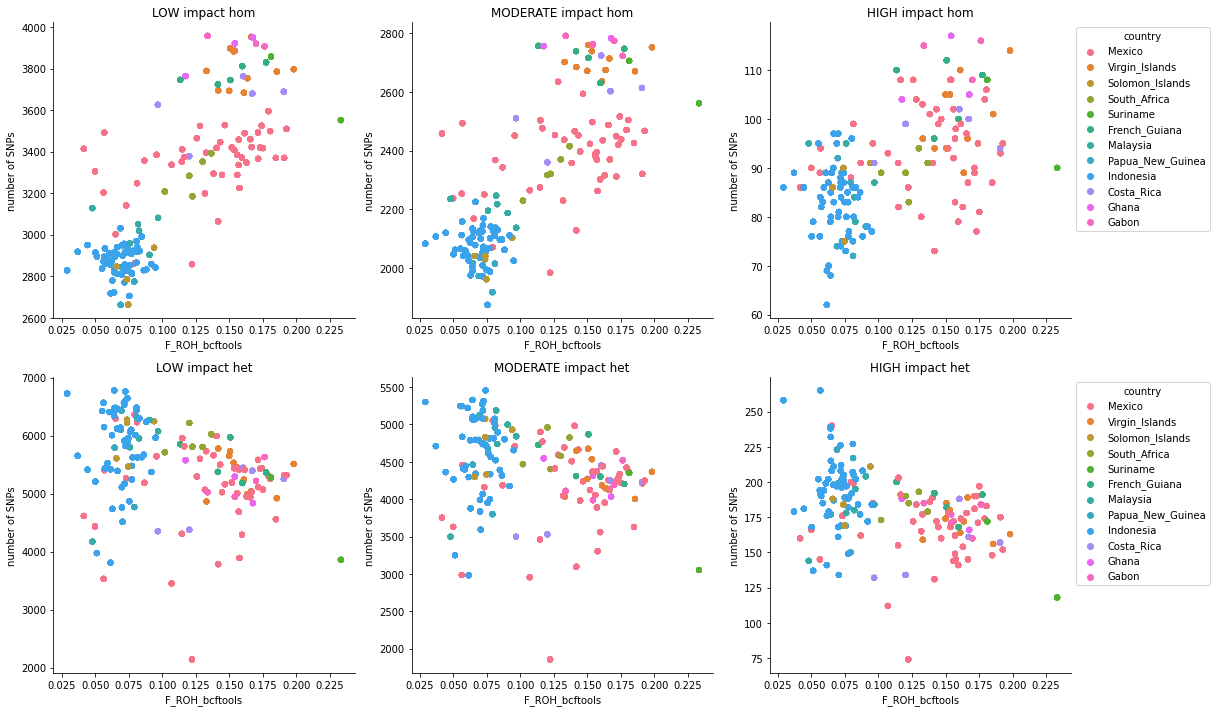

In [24]:
var = 'snps'
df_temp = df_ROH_bcftools_plink[(df_ROH_bcftools_plink['variant'] == var)]

states = list(set(df_temp['state']))
impacts = list(set(df_temp['impact']) - set(['MODIFIER']))

fig, axes = plt.subplots(2, 3, figsize = (17, 10))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        axi = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

        sns.scatterplot(ax=axi, data=dfi, x='F_ROH_bcftools', y='number', hue='country', linewidth=0)
    #     axi.set(xlim=(-0.1, 1.1))
        axi.set_title('{} impact {}'.format(impact, state))
        axi.set_ylabel('number of SNPs')
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

## 3.3. Compare PLINK and bcftools F_ROH
### => high correlation, except for depth outliers

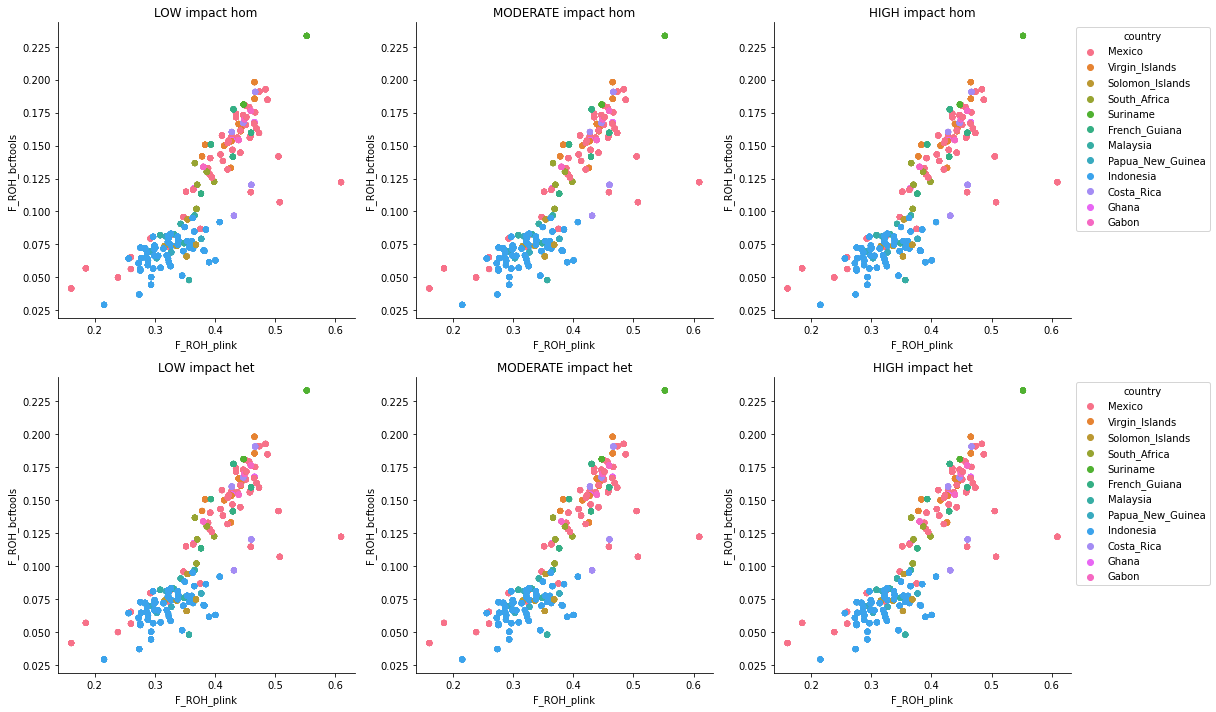

In [30]:
var = 'snps'
df_temp = df_ROH_bcftools_plink[(df_ROH_bcftools_plink['variant'] == var)]

states = list(set(df_temp['state']))
impacts = list(set(df_temp['impact']) - set(['MODIFIER']))

fig, axes = plt.subplots(2, 3, figsize = (17, 10))

for j in range(len(states)):
    for i in range(len(impacts)):
        state = states[j]
        impact = impacts[i]
        axi = axes[j][i]
        dfi = df_temp[(df_temp['impact'] == impact) & (df_temp['state'] == state)]

        sns.scatterplot(ax=axi, data=dfi, x='F_ROH_plink', y='F_ROH_bcftools', hue='country', linewidth=0)
#         axi.set(xlim=(0, 1), ylim=(0, 0.5))
        axi.set_title('{} impact {}'.format(impact, state))
        if i != 2:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()